# Sidekick - Exploratory Data Analysis
We explore the data in the Sidekick dataset.

In [12]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick

DATA_DIR = "../data/sidekick"

def extract_jumps_and_times(project):
    duration = project.deadline - project.start_date
    jumps = np.diff(project.money * project.goal)
    # -1 as first index to count the first jump (between 0 and the first pledge)
    times = np.diff([-1] + [i / 1000 * duration for i, j in enumerate(jumps) if j != 0])
    jumps = filter(lambda j: j != 0, jumps)
    return jumps, times

def show_histogram(y, x_label, y_label, title="", x_scale='linear', y_scale='linear', bins=100, density=False, 
                   width=0.7, color='b', file_name=None, plot=True):
    hist, bins = np.histogram(y, bins=bins, density=density)
    w = width * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(center, hist, align='center', width=w, color=color)
    # Make counts of 1 visible in log scale
    ax.set_ylim(0.9, ax.get_ylim()[1] + 0.1 * ax.get_ylim()[1])
    ax.set_yscale(y_scale)
    ax.set_xscale(x_scale)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    if file_name:
        plt.savefig(file_name)
    if plot:
        plt.show()
    return hist, bins
    
def generate_jumps_times(iterable_collection_of_project):
    jumps = []
    times = []
    for project in iterable_collection_of_project:
        j, t = extract_jumps_and_times(project)
        jumps.extend(j)
        times.extend(t)
    return jumps, times

### Load data

In [2]:
sk = Sidekick()
sk.load()
#train, test = sk.split(threshold=0.7)
#successful = [p for p in train if p.successful]
#failed = [p for p in train if not p.successful]
successful = sk.successful()
failed = sk.failed()
total_successful = len(successful)
total_failed = len(failed)
print("Number of projects:", total_successful + total_failed)
print("Number of successful:", total_successful)
print("Number of fail:", total_failed)

Loading data set...
Data loaded.
Number of projects: 15899
Number of successful: 7596
Number of fail: 8303


## Project
Display an arbitrary or randomly selected project.

Goal: $3000
Pledged: $3834


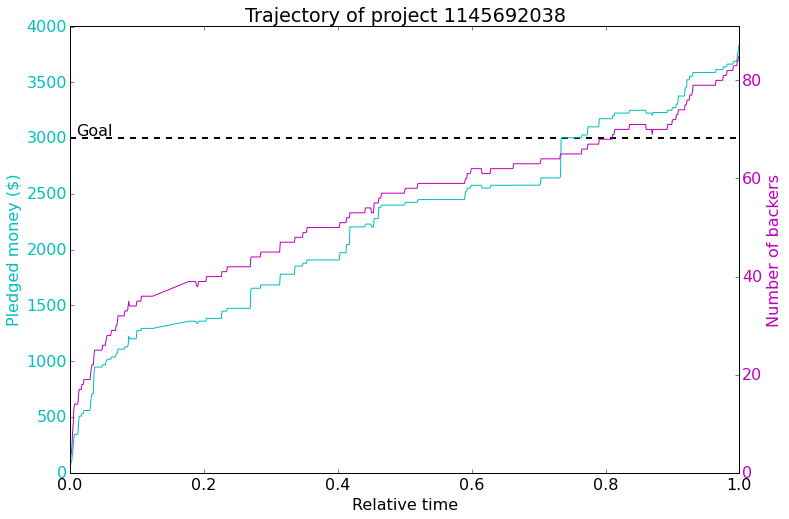

Project 1145692038 is successful


In [19]:
project = sk.choose_n_projects(n=100)[22]
#project = sk['14035777']
project.plot(file_name="trajectory_successful.pdf")
print(project)

## Histograms
First we plot the histograms for the distribution of increase in money and time between jumps for all the projects, only the succesful ones and only the failed ones.

### Global
We consider first all the projects.

In [13]:
jumps, times = generate_jumps_times(sk)

#### Global - Histogram of jumps

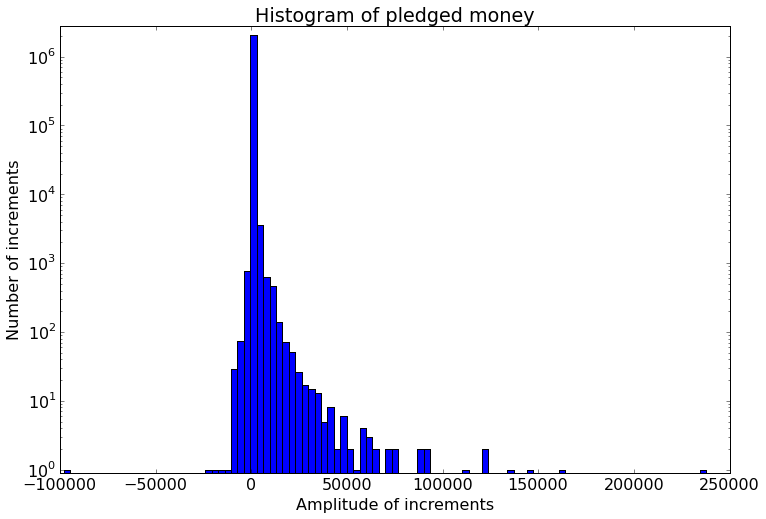

In [5]:
hist, bins = show_histogram(jumps, 
               title="Histogram of pledged money",
               x_label='Amplitude of increments', 
               y_label='Number of increments', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1,
               file_name="histogram_increments.pdf")

#### Global - Histogram of times

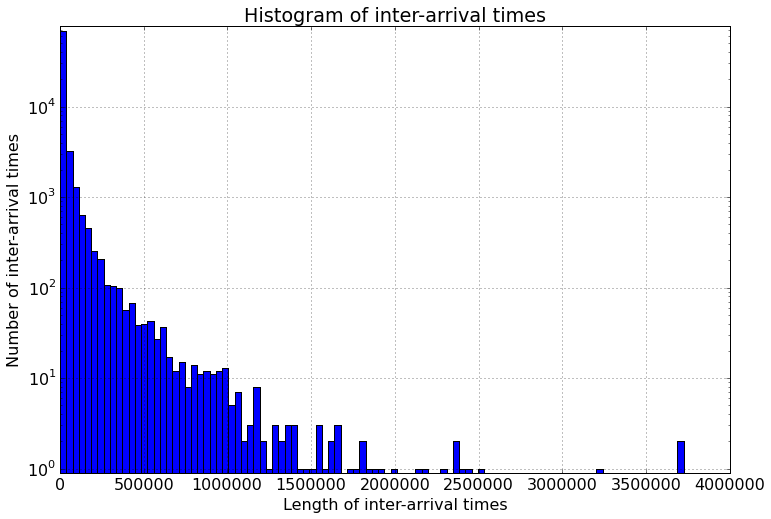

523
(0.99999999999267364, 18040.01622172218)
[67632  3236  1304   633   458   252   207   108   103   100    57    67
    39    40    43    27    37    17    12    15     8    14    11    12
    11    12    13     5     7     2     3     8     2     1     3     2
     3     3     1     1     1     3     1     2     3     0     1     1
     2     1     1     1     0     1     0     0     0     1     1     0
     0     1     0     2     1     1     0     1     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     1     0     0     0     0     0     0     0     0     0
     0     0     0     2] [  1.00000000e+00   3.72501825e+04   7.44993650e+04   1.11748548e+05
   1.48997730e+05   1.86246913e+05   2.23496095e+05   2.60745278e+05
   2.97994460e+05   3.35243643e+05   3.72492825e+05   4.09742008e+05
   4.46991190e+05   4.84240373e+05   5.21489555e+05   5.58738738e+05
   5.95987920e+05   6.33237103e+05   6.70486285e+05   7.07735468e+05


In [14]:
# Keep only project within the given range
projects_filtered = [p for p in sk if p.money[-1] >= 0.5 and p.money[-1] <= 1.0]
jumps, times = generate_jumps_times(projects_filtered)

hist, bins = show_histogram(times, 
               title="Histogram of inter-arrival times",
               x_label='Length of inter-arrival times', 
               y_label='Number of inter-arrival times', 
               x_scale='linear', 
               y_scale='linear', 
               bins=100,
               density=False,
               width=1,
               file_name=None,
               plot=False)

# Fit an exponential
from scipy.stats import expon
x = np.linspace(0, 1000, 1000)
param = expon.fit(times)
pdf_fitted = expon.pdf(x, loc=param[0], scale=param[1])
plt.plot(x, pdf_fitted * np.sum(hist), 'r-')
plt.yscale('log')
plt.grid()
plt.show()

print(len(projects_filtered))
print(param)
print(hist, bins)

### Successful projects
We consider now only the successful projects.

In [15]:
jumps_successful, times_successful = generate_jumps_times(successful)

#### Successful - Histogram of jumps

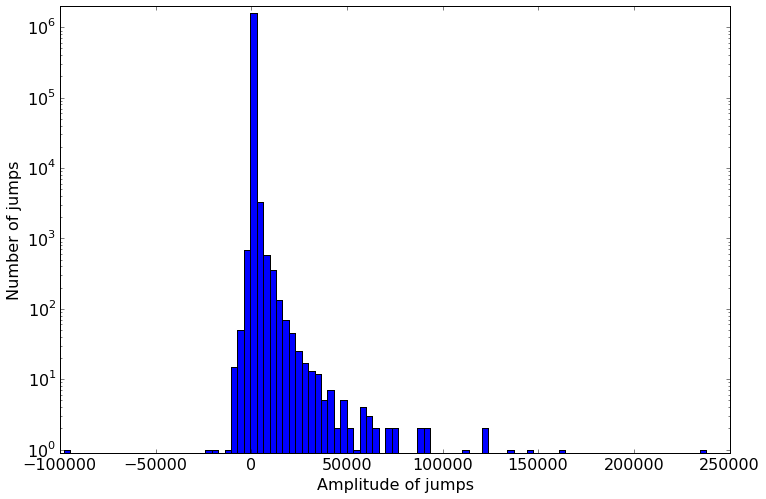

In [7]:
hist, bins = show_histogram(jumps_successful, 
               x_label='Amplitude of jumps', 
               y_label='Number of jumps', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

#### Successful - Histogram of times

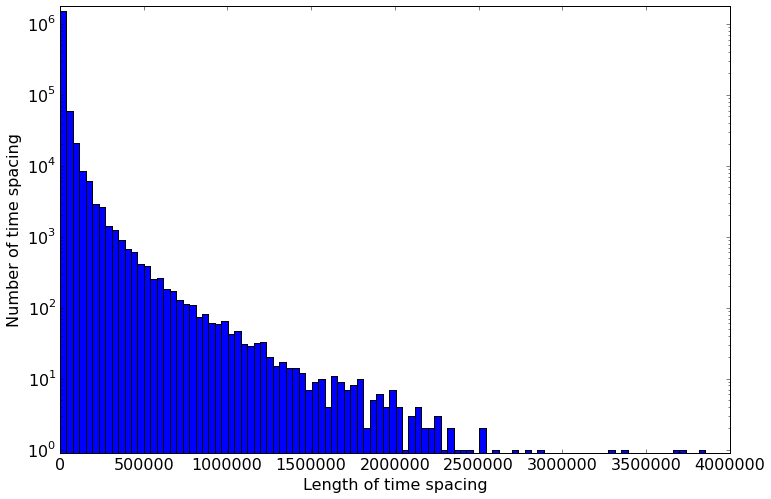

In [16]:
hist, bins = show_histogram(times_successful, 
               x_label='Length of time spacing', 
               y_label='Number of time spacing', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

### Failed projects
We consider now only the failed projects.

In [17]:
jumps_failed, times_failed = generate_jumps_times(failed)

#### Failed - Histogram of jumps

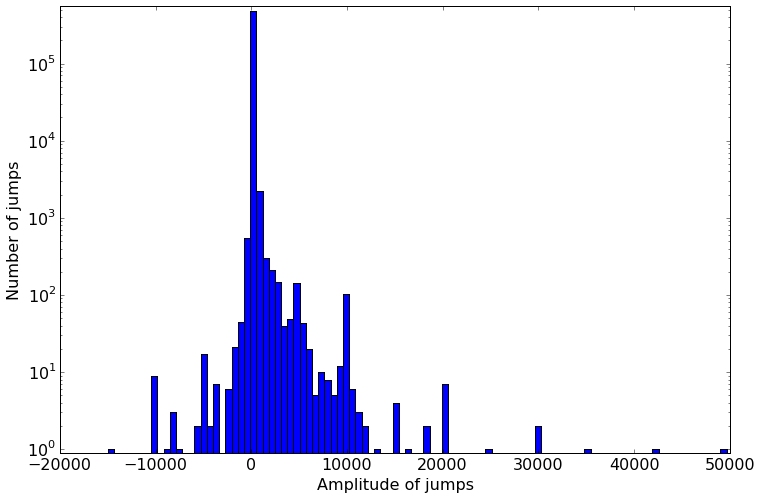

In [18]:
hist, bins = show_histogram(jumps_failed, 
               x_label='Amplitude of jumps', 
               y_label='Number of jumps', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

#### Failed - Histogram of times

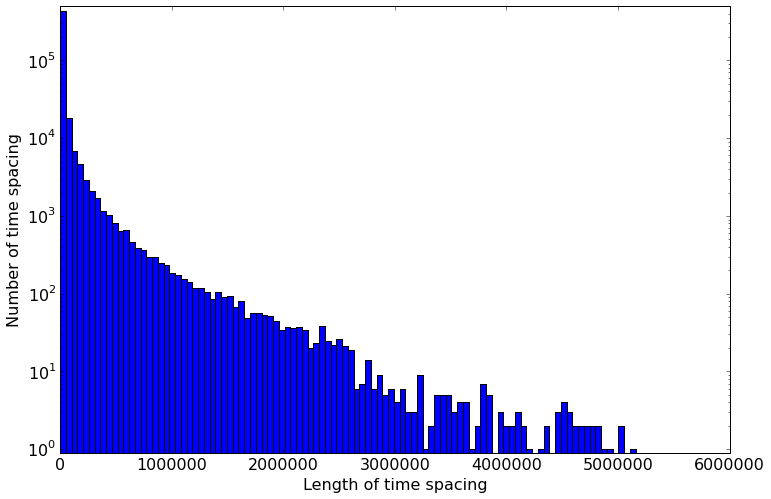

In [19]:
hist, bins = show_histogram(times_failed, 
               x_label='Length of time spacing', 
               y_label='Number of time spacing', 
               x_scale='linear', 
               y_scale='log',
               bins=100,
               width=1)

## Outliers
We take a look at the outliers in the total amount of pledeged money for the successful and the failed projects separately.

### Outliers - Successful

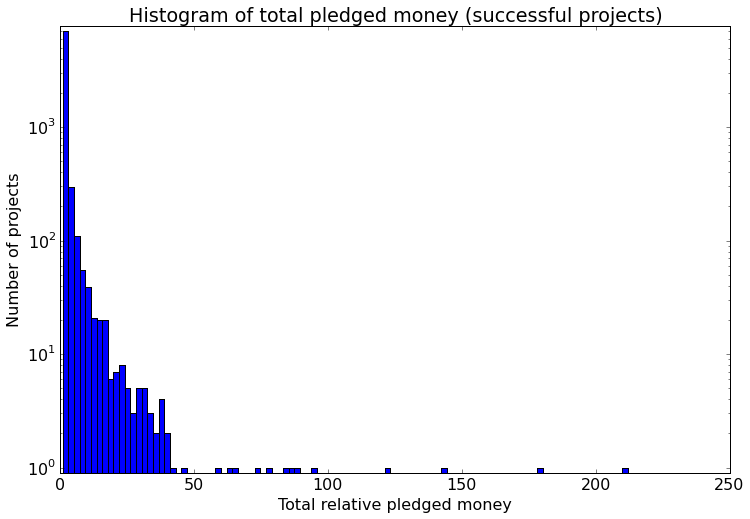

[6970  295  110   55   39   21   20   20    6    7    8    5    3    5    5
    3    2    4    2    1    0    1    0    0    0    0    0    1    0    1
    1    0    0    0    1    0    1    0    0    1    1    1    0    0    1
    0    0    0    0    0    0    0    0    0    0    0    0    1    0    0
    0    0    0    0    0    0    0    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1]
[   1.            3.11060603    5.22121206    7.33181809    9.44242412
   11.55303015   13.66363618   15.77424221   17.88484824   19.99545426
   22.10606029   24.21666632   26.32727235   28.43787838   30.54848441
   32.65909044   34.76969647   36.8803025    38.99090853   41.10151456
   43.21212059   45.32272662   47.43333265   49.54393868   51.65454471
   53.76515074   55.87575676   57.98636279   60.09696882   62.20757485
   64.31818088   66.42878691   68.53939294   70.64999897   72.7606

In [31]:
goal_successful = [project.money[-1] for project in successful if project.money[-1] < 400]
hist, bins = show_histogram(goal_successful,
               title="Histogram of total pledged money (successful projects)",
               x_label='Total relative pledged money',
               y_label='Number of projects',
               x_scale='linear',
               y_scale='log',
               bins=100,
               width=1,
               file_name="histogram_successful_total_money.pdf")
print(hist)
print(bins)
print(len(sorted([g for g in goal_successful if g > 38.5])))

###  Outliers - Failed

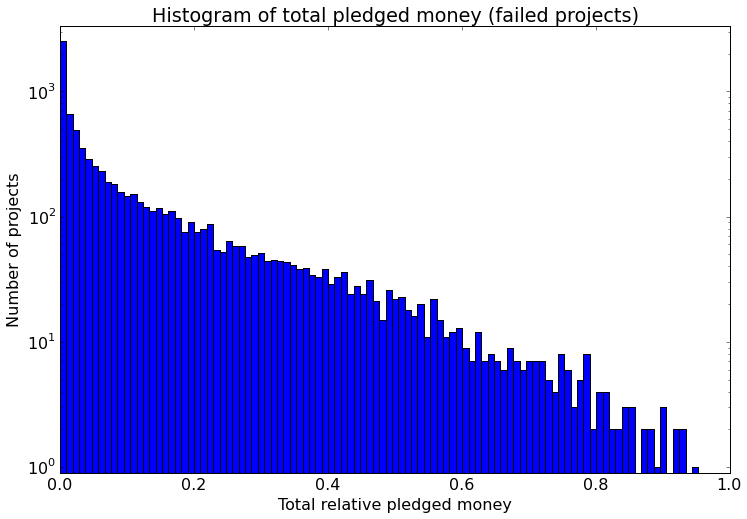

In [43]:
goal_failed = [project.money[-1] for project in sk if not project.successful]
hist, bins = show_histogram(goal_failed,
                            title="Histogram of total pledged money (failed projects)",
                            x_label='Total relative pledged money',
                            y_label='Number of projects',
                            x_scale='linear',
                            y_scale='log',
                            bins=100,
                            width=1,
                            file_name="histogram_failed_total_money.pdf")

## Prototypes
We display here the "prototypical" successful and failed projects by their mean and averaged standard deviation. We notice that there a clear difference between the two, even with very few observations. Therefore, there is definitely a way to discriminate between the two, but the current approach is not correct.

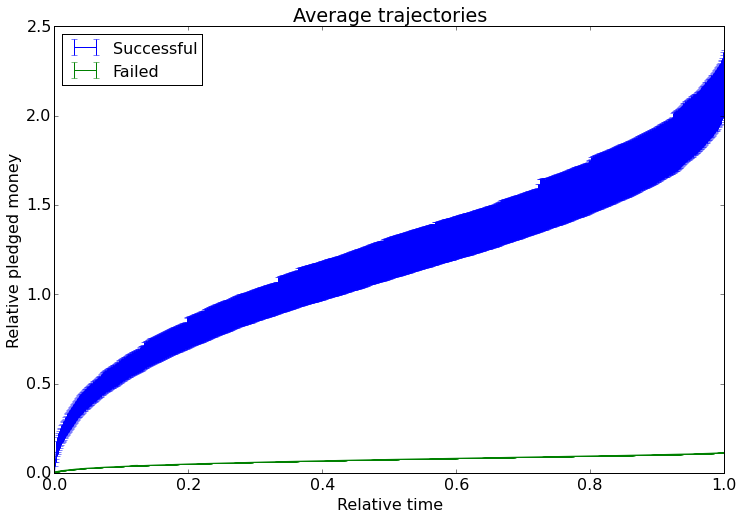

In [28]:
money_successful = [p.money for p in successful]
money_failed = [p.money for p in failed]
mean_s = np.mean(money_successful, axis=0)
std_s = np.std(money_successful, axis=0)
mean_f = np.mean(money_failed, axis=0)
std_f = np.std(money_failed, axis=0)
x = np.linspace(0, 1, 1000)
plt.errorbar(x, mean_s, std_s / np.sqrt(len(successful)), label="Successful")
plt.errorbar(x, mean_f, std_f / np.sqrt(len(failed)), label="Failed")
plt.legend(loc=2)
plt.title("Average trajectories")
plt.xlabel('Relative time')
plt.ylabel('Relative pledged money')
plt.savefig("two_profiles.pdf")
plt.show()

## Output as input
We visualize the final state of a project $y_T$ versus its state at time $t$ $y_t$. That is, we consider $y_T$ as the target to be predicted and $y_t$ as a feature. The idea is, for a given project $p$, to use $\mathbf{y}_{1:t}^{(p)}$ as features to predict $y_T^{(p)}$

### Output as input - Global

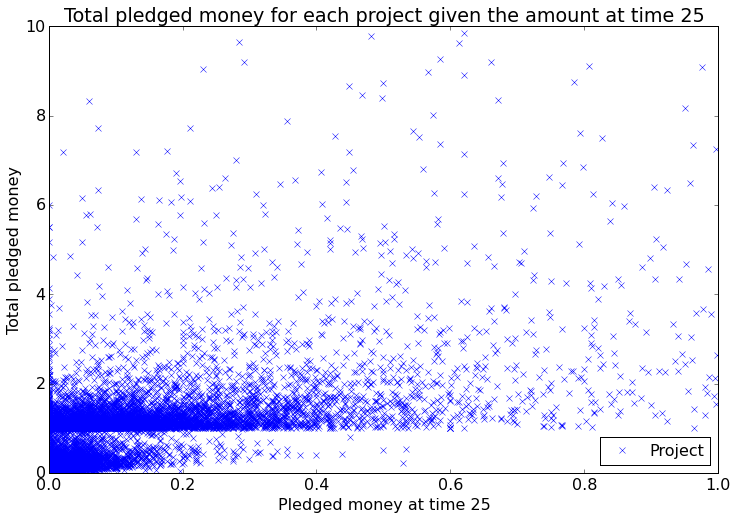

In [21]:
T = 999
t = 25
yt = [p.money[t] for p in sk if p.money[T] < 10 and p.money[t] < 1]
yT = [p.money[T] for p in sk if p.money[T] < 10 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)
plt.title('Total pledged money for each project given the amount at time %s' % t)
plt.savefig('input_output_global.pdf')
plt.show()

###  Output as input - Successful

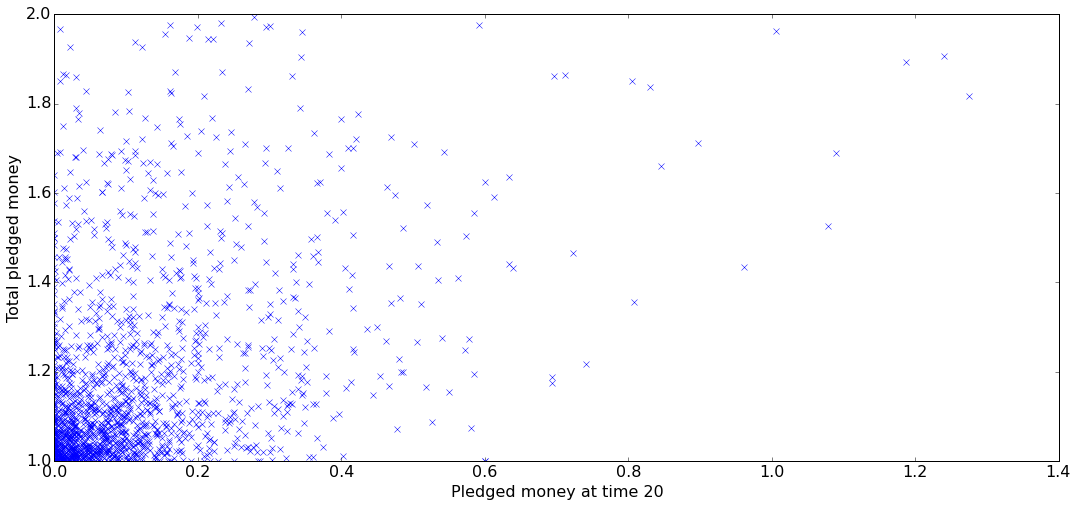

In [50]:
T = 999
t = 20
N = 2000
successful_light = successful[:N]
successful_light = [s for s in successful_light if s.money[T] < 2]
yt = [p.money[t] for p in successful_light]
yT = [p.money[T] for p in successful_light]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.show()

###  Output as input - Failed

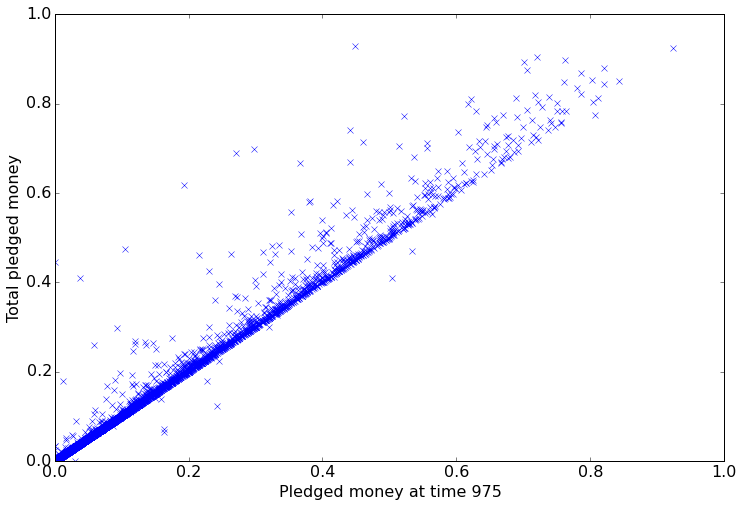

In [4]:
T = 999
t = 975
yt = [p.money[t] for p in failed if p.money[T] < 100 and p.money[t] < 1]
yT = [p.money[T] for p in failed if p.money[T] < 100 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.show()

## Clustering: Goal vs Duration

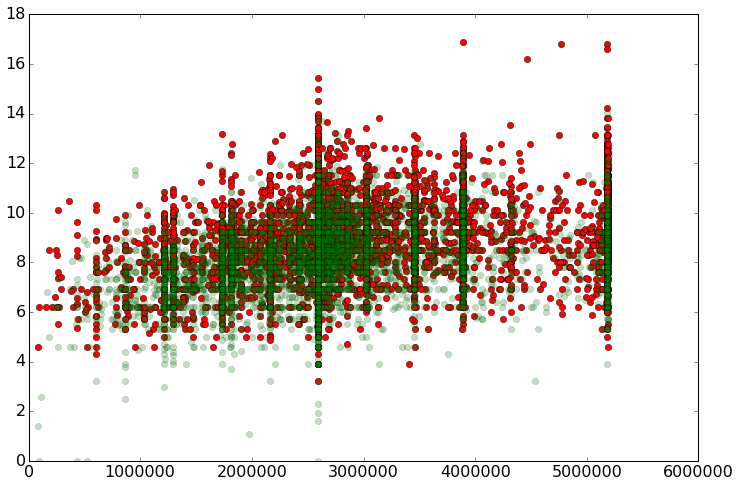

In [46]:
T = 999
outlier = 1e9 
y_successful = [np.log(p.goal) for p in sk if p.goal < outlier and p.successful]
x_successful = [p.deadline - p.start_date for p in sk if p.goal < outlier and p.successful]
y_failed = [np.log(p.goal) for p in sk if p.goal < outlier and not p.successful]
x_failed = [p.deadline - p.start_date for p in sk if p.goal < outlier and not p.successful]
plt.plot(x_failed, y_failed, 'or', alpha=1)
plt.plot(x_successful, y_successful, 'og', alpha=0.25)
plt.show()

## Histogram of goals

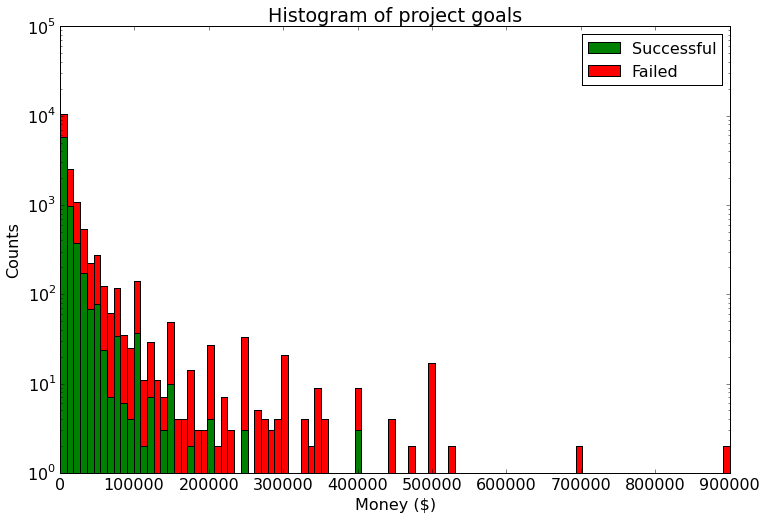

In [78]:
outlier = 1e6
width = 1
bins = 100
goals_successful = [p.goal for p in sk if p.goal < outlier and p.successful]
goals_failed = [p.goal for p in sk if p.goal < outlier and not p.successful]

hist_successful, bins = np.histogram(goals_successful, bins=bins)
hist_failed, bins = np.histogram(goals_failed, bins=bins)
w = width * (bins[1] - bins[0])
left = bins[:-1]

plt.bar(left, hist_successful, width=w, color='g', label="Successful")
plt.bar(left, hist_failed, bottom=hist_successful, width=w, color='r', label='Failed')
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Money ($)')
plt.title('Histogram of project goals ')
plt.legend()
plt.show()